In [86]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw
import pickle
import matplotlib as mpl
import cmocean
from scipy import stats as spst
import scipy.optimize as scopt

%matplotlib inline

In [92]:
# conversion factor
r_uE_W=1/0.2174 # (uE/m2/s) / (W/m2)

In [206]:
basedir='/data/eolson/results/MEOPAR/PARcalcs/'
dbname='DFO_CTD_withModelPAR.sqlite'
datelims=()
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


In [ ]:
session.query(ObsTBL.PAR1_units).distinct().all()

In [ ]:
session.query(ObsTBL.PAR_1_units).distinct().all()

In [ ]:
PAR=case([(ObsTBL.PAR!=None, ObsTBL.PAR)], else_=
             case([(ObsTBL.PAR1!=None, ObsTBL.PAR1)], else_=ObsTBL.PAR_1))

In [ ]:
SA=case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_= None)))
CT=case([(CalcsTBL.Temperature_Primary_CT!=None, CalcsTBL.Temperature_Primary_CT)], else_=
         case([(CalcsTBL.Temperature_Secondary_CT!=None, CalcsTBL.Temperature_Secondary_CT)], else_=CalcsTBL.Temperature_CT))
ZD=case([(ObsTBL.Depth!=None,ObsTBL.Depth)], else_= CalcsTBL.Z)

In [ ]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                StationTBL.Lat,StationTBL.Lon,ZD.label('Z'),PAR.label('PAR'),SA.label('SA'),CT.label('CT')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0))


In [ ]:
qry2=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                StationTBL.Lat,StationTBL.Lon,func.min(ZD).label('minZ')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0)).group_by(StationTBL.ID)
minzQ=session.query(StationTBL.ID,func.min(ZD).label('minZ')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0)).group_by(StationTBL.ID)

In [ ]:
df2=pd.DataFrame(qry2.all())


In [ ]:
df3=pd.DataFrame(minzQ.all())

In [ ]:
df1=pd.DataFrame(qry.all())

In [ ]:
len(df2),len(df1),len(df3)

In [ ]:
subminzQ=minzQ.subquery()
subqry=qry.subquery()

In [ ]:
sparQ=session.query(subminzQ.c.ID,subminzQ.c.minZ,subqry.c.PAR).select_from(subminzQ).join(subqry,and_(
    ObsTBL.)

In [ ]:
df1=pd.DataFrame(qry.all())
df1['dtUTC']=[dt.datetime(int(y),int(m),int(d))+dt.timedelta(hours=h) for y,m,d,h in zip(df1['Year'],df1['Month'],df1['Day'],df1['Hour'])]


In [ ]:
len(df1)

In [ ]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(df1['Lon'],df1['Lat'],'k.')
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))

In [ ]:
df1.head()

In [ ]:
df1.tail()

In [ ]:
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'PAR':'carp_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'carp_T':1,'grid_T':1}
PATH='/results/SalishSea/nowcast-green.201812/'
data=et.matchData(df1,filemap,fdict,dt.datetime(2015,1,1),dt.datetime(2018,1,1),namfmt,PATH,flen)

In [ ]:
basedir='/data/eolson/results/MEOPAR/PARcalcs/'
dbname='DFOCTDwithModel.sqlite'
datelims=()
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


In [ ]:
pickle.dump(data,open('loadPARCTD.pkl','wb'))

In [122]:
data=pickle.load(open('loadPARCTD2.pkl','rb'))

In [123]:
data.drop(data[data.k<0].index,inplace=True)
data['mod_PAR']=data['mod_PAR']*r_uE_W

In [124]:
data

,ID,staFile,obsFile,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC,j,i,mod_PAR,mod_vosaline,mod_votemper,k
0,1001,"req20181116/EO UBC November 16, 2018 (2015 dat...","req20181116/EO UBC November 16, 2018 (2015 dat...",2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.983099,0.2,29.849611,8.942753,2015-02-11 05:17:46,328,240,0.0,29.437077,9.076343,1
1,1001,"req20181116/EO UBC November 16, 2018 (2015 dat...","req20181116/EO UBC November 16, 2018 (2015 dat...",2015.0,2.0,11.0,5.296111,48.613333,-123.243833,2.974641,0.1,29.852177,8.942511,2015-02-11 05:17:46,328,240,0.0,29.539558,9.086275,2
2,1001,"req20181116/EO UBC November 16, 2018 (2015 dat...","req20181116/EO UBC November 16, 2018 (2015 dat...",2015.0,2.0,11.0,5.296111,48.613333,-123.243833,3.966178,0.1,29.869012,8.941135,2015-02-11 05:17:46,328,240,0.0,29.665234,9.094213,3
3,1001,"req20181116/EO UBC November 16, 2018 (2015 dat...","req20181116/EO UBC November 16, 2018 (2015 dat...",2015.0,2.0,11.0,5.296111,48.613333,-123.243833,4.957711,0.0,29.915690,8.936661,2015-02-11 05:17:46,328,240,0.0,29.739351,9.096522,4
4,1001,"req20181116/EO UBC November 16, 2018 (2015 dat...","req20181116/EO UBC November 16, 2018 (2015 dat...",2015.0,2.0,11.0,5.296111,48.613333,-123.243833,5.949239,0.0,29.913935,8.936489,2015-02-11 05:17:46,328,240,0.0,29.781431,9.099732,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203053,4862,"req20181116/EO UBC November 16, 2018 (2017 dat...","req20181116/EO UBC November 16, 2018 (2017 dat...",2017.0,10.0,9.0,8.238889,49.238333,-123.845667,244.800000,0.0,31.318198,9.686366,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32
203054,4862,"req20181116/EO UBC November 16, 2018 (2017 dat...","req20181116/EO UBC November 16, 2018 (2017 dat...",2017.0,10.0,9.0,8.238889,49.238333,-123.845667,245.800000,0.0,31.318619,9.687753,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32
203055,4862,"req20181116/EO UBC November 16, 2018 (2017 dat...","req20181116/EO UBC November 16, 2018 (2017 dat...",2017.0,10.0,9.0,8.238889,49.238333,-123.845667,246.700000,0.0,31.318937,9.688650,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32
203056,4862,"req20181116/EO UBC November 16, 2018 (2017 dat...","req20181116/EO UBC November 16, 2018 (2017 dat...",2017.0,10.0,9.0,8.238889,49.238333,-123.845667,247.900000,0.0,31.318758,9.687919,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32


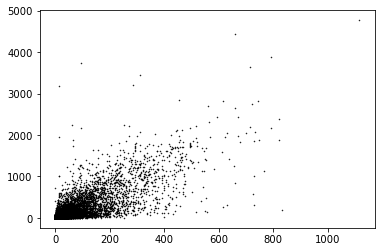

In [125]:
plt.plot(data['mod_PAR'],data['PAR'],'k.',ms=1)

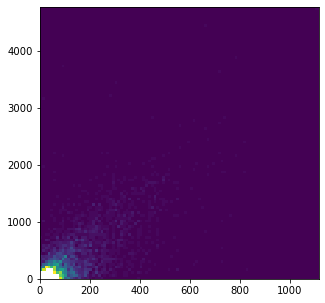

In [126]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
xx=data.loc[ii,['mod_PAR']].values
yy=data.loc[ii,['PAR']].values
ax.hist2d(xx[:,0],yy[:,0],bins=100,cmin=0,cmax=50);

Text(0.5, 1.0, 'PAR Direct Comparison: HC201812')

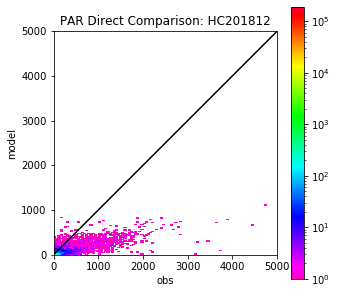

In [204]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_PAR']].values
xx=data.loc[ii,['PAR']].values
_,_,_,m=ax.hist2d(xx[:,0],yy[:,0],bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,5000)
ax.set_ylim(0,5000)
ax.set_aspect(1)
ax.plot((0,5000),(0,5000),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison: HC201812')

Text(0.5, 1.0, 'PAR Direct Comparison: HC201812')

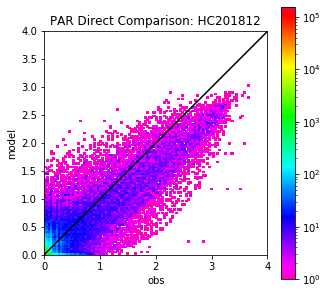

In [127]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_PAR']].values
xx=data.loc[ii,['PAR']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('log10 PAR Direct Comparison: HC201812')

In [128]:
data.keys()

Index(['ID', 'staFile', 'obsFile', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR',
       'mod_vosaline', 'mod_votemper', 'k'],
      dtype='object')

In [129]:
stas=data.groupby(by=['Year','Month','Day','Lat','Lon'])

In [130]:
stas

In [131]:
with nc.Dataset('/results/SalishSea/nowcast-green.201812/01jan16/SalishSea_1h_20160101_20160101_ptrc_T.nc') as ftemp:
    deptht=ftemp.variables['deptht'][:]

In [132]:
deptht[5]

5.5001507

In [133]:
data['mod_Z']=[deptht[ii] for ii in data['k']]

Text(0, 0.5, 'Model')

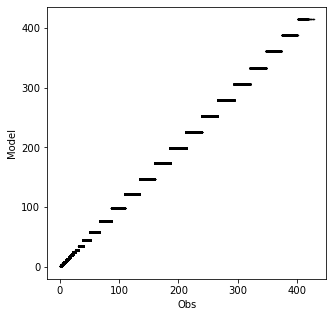

In [134]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(data['Z'],data['mod_Z'],'k.',ms=1)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')

Text(0.5, 1.0, 'PAR Direct Comparison Upper 10m: HC201812')

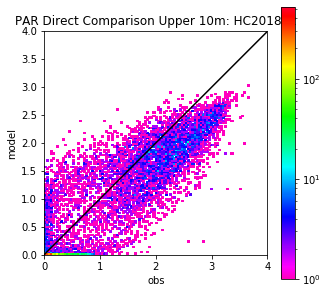

In [135]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<10
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 10m: HC201812')

Text(0.5, 1.0, 'PAR Direct Comparison Upper 10m: HC201812')

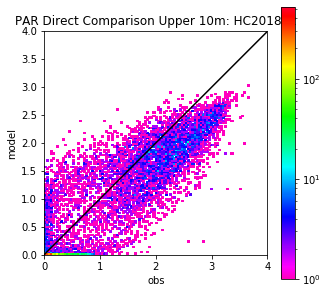

In [135]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<10
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Bias vs depth: HC201812')

Text(0.5, 1.0, 'hist: model z - obs z')

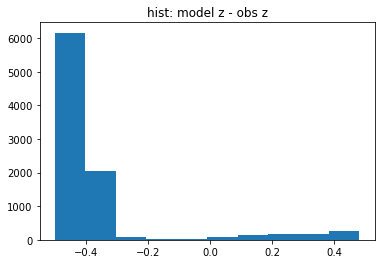

In [136]:
plt.hist(yz-xz)
plt.title('hist: model z - obs z')

Text(0, 0.5, 'log10(model PAR +1)-log10(obs PAR +1)')

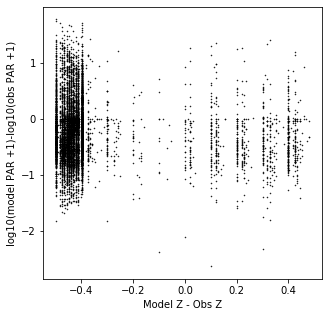

In [137]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(yz-xz,np.log10(yy[:,0]+1)-np.log10(xx[:,0]+1),'k.',ms=1)
ax.set_xlabel('Model Z - Obs Z')
ax.set_ylabel('log10(model PAR +1)-log10(obs PAR +1)')

Text(0.5, 1.0, 'PAR Direct Comparison Upper 2m: HC201812')

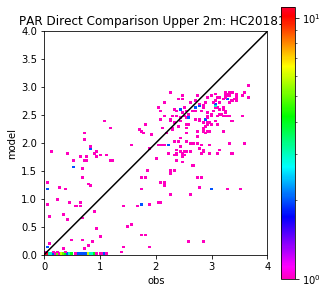

In [138]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<2
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 2m: HC201812')

In [139]:
data.keys()

Index(['ID', 'staFile', 'obsFile', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR',
       'mod_vosaline', 'mod_votemper', 'k', 'mod_Z'],
      dtype='object')

In [140]:
temp=data.loc[(data['PAR']>0)&(data['mod_PAR']==0)&(data['Z']<3),['dtUTC','Lat','Lon','Z','mod_Z','Hour']]

In [141]:
temp

,dtUTC,Lat,Lon,Z,mod_Z,Hour
0,2015-02-11 05:17:46,48.613333,-123.243833,1.983099,1.500003,5.296111
1,2015-02-11 05:17:46,48.613333,-123.243833,2.974641,2.500011,5.296111
216,2015-02-11 11:04:07,48.300833,-124.000333,1.983156,1.500003,11.068611
1677,2015-04-02 05:26:41,48.486500,-123.153500,1.983122,1.500003,5.444722
1678,2015-04-02 05:26:41,48.486500,-123.153500,2.974676,2.500011,5.444722
...,...,...,...,...,...,...
202062,2017-10-09 06:50:44,49.318333,-123.799667,1.000000,0.500000,6.845556
202063,2017-10-09 06:50:44,49.318333,-123.799667,2.000000,1.500003,6.845556
202402,2017-10-09 07:30:05,49.280000,-123.824167,2.000000,1.500003,7.501389
202807,2017-10-09 08:14:20,49.238333,-123.845667,1.300000,1.500003,8.238889


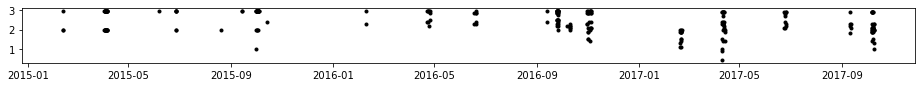

In [142]:
fig,ax=plt.subplots(1,1,figsize=(16,1))
ax.plot(temp['dtUTC'],temp['Z'],'k.')

(array([11., 16., 39., 41., 42., 34., 25., 17., 11., 10.]),
 array([ 3.26666667,  4.32227778,  5.37788889,  6.4335    ,  7.48911111,
         8.54472222,  9.60033333, 10.65594444, 11.71155556, 12.76716667,
        13.82277778]),
 <a list of 10 Patch objects>)

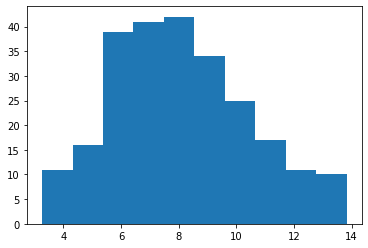

In [143]:
plt.hist(temp['Hour'])

In [144]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

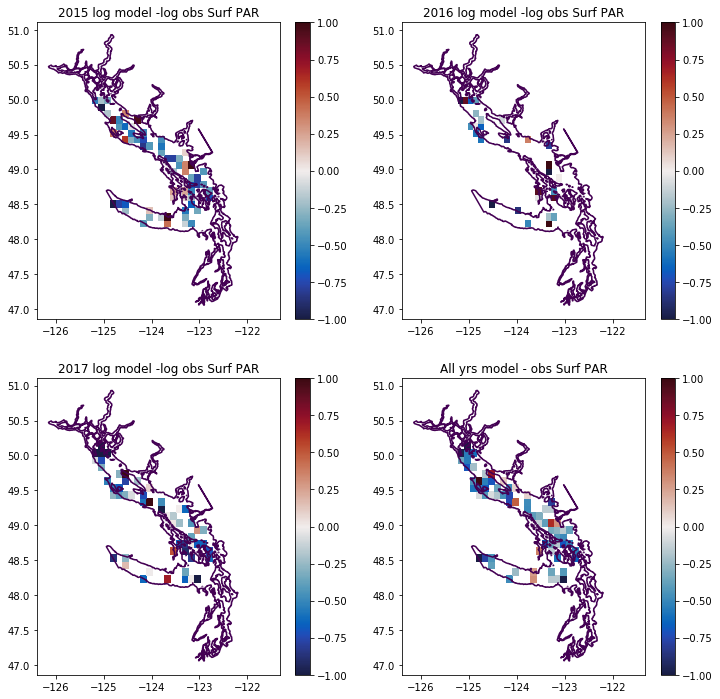

In [191]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2018):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['PAR'])&(data['mod_PAR']>=0)&(data['Z']<2)]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' log model -log obs Surf PAR')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                np.log10(dyr['mod_PAR']+1)-np.log10(dyr['PAR']+1), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1,vmax=1,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['PAR'])&~np.isnan(data['mod_PAR'])&(data['Z']<2)]
yr=yr+1
ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[yr-2015].set_title('All yrs model - obs Surf PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           np.log10(dyr['mod_PAR']+1)-np.log10(dyr['PAR']+1), 
            statistic='mean', bins=20)
m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1,vmax=1,shading='flat')
plt.colorbar(m,ax=ax[yr-2015])

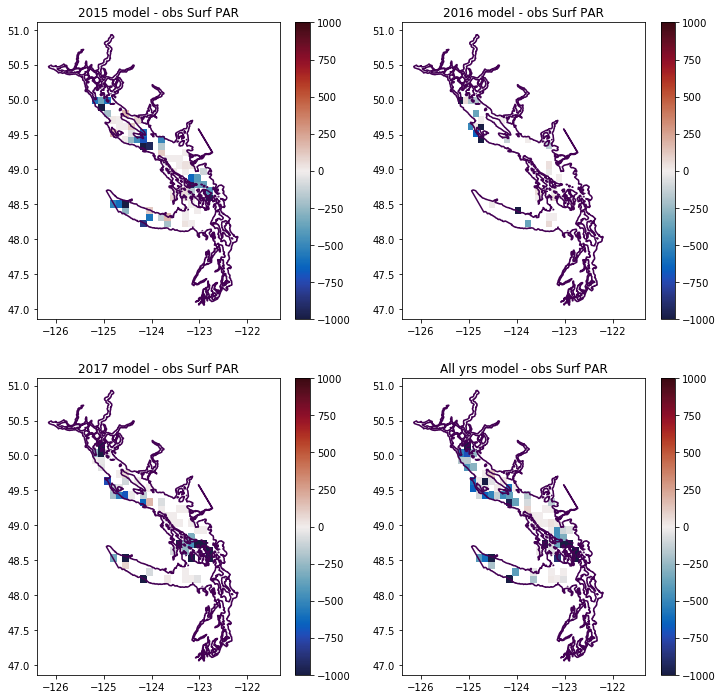

In [192]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2018):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['PAR'])&(data['mod_PAR']>=0)&(data['Z']<2)]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' model - obs Surf PAR')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
               dyr['mod_PAR']-dyr['PAR'], 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['PAR'])&~np.isnan(data['mod_PAR'])&(data['Z']<2)]
yr=yr+1
ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[yr-2015].set_title('All yrs model - obs Surf PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_PAR']-dyr['PAR'], 
            statistic='mean', bins=20)
m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
plt.colorbar(m,ax=ax[yr-2015])

Where model or obs PAR>100 muE/m2/s


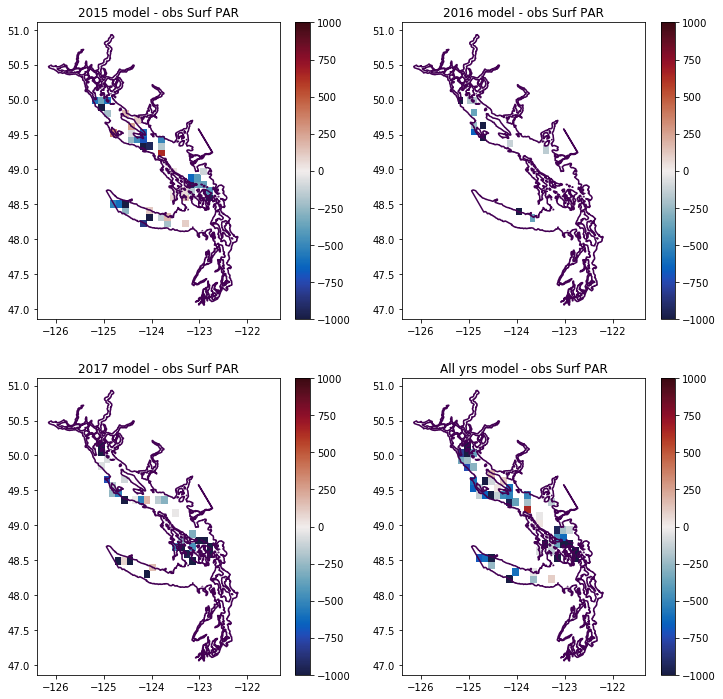

In [201]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
print('Where model or obs PAR>100 muE/m2/s')
ax=ax.flatten()
for yr in range(2015,2018):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&((data['PAR']>=100)|(data['mod_PAR']>=100))&(data['Z']<2)]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' model - obs Surf PAR')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                dyr['mod_PAR']-dyr['PAR'], 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&((data['PAR']>=100)|(data['mod_PAR']>=100))&(data['Z']<2)]
yr=yr+1
ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[yr-2015].set_title('All yrs model - obs Surf PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_PAR']-dyr['PAR'], 
            statistic='mean', bins=20)
m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
plt.colorbar(m,ax=ax[yr-2015])

Where model or obs PAR>100 muE/m2/s


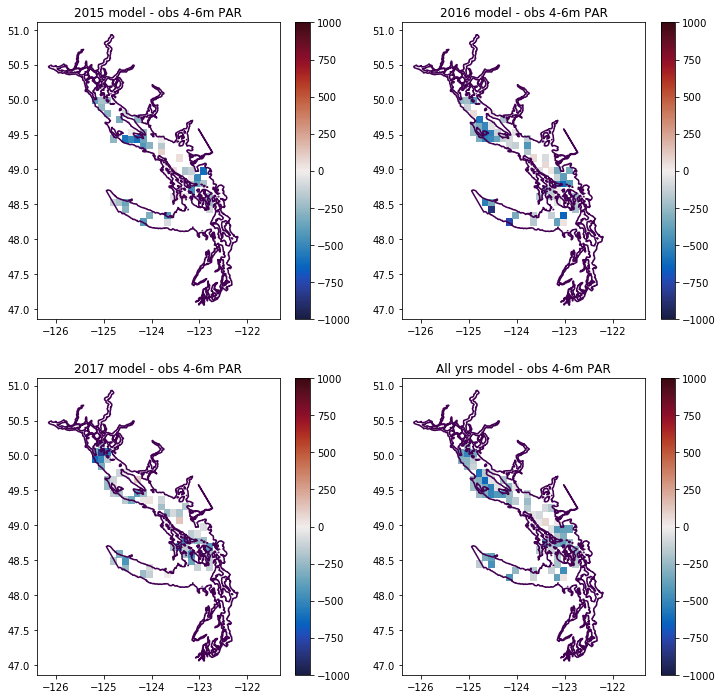

In [202]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
print('Where model or obs PAR>100 muE/m2/s')
ax=ax.flatten()
for yr in range(2015,2018):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&((data['PAR']>=100)|(data['mod_PAR']>=100))&(data['Z']<6)&(data['Z']>4)]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' model - obs 4-6m PAR')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                dyr['mod_PAR']-dyr['PAR'], 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&((data['PAR']>=100)|(data['mod_PAR']>=100))&(data['Z']<6)&(data['Z']>4)]
yr=yr+1
ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[yr-2015].set_title('All yrs model - obs 4-6m PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_PAR']-dyr['PAR'], 
            statistic='mean', bins=20)
m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
plt.colorbar(m,ax=ax[yr-2015])

In [147]:
np.max(data['mod_PAR'])

1115.3527674810975

In [148]:
1/0.2174

4.599816007359705

In [149]:
data.keys()

Index(['ID', 'staFile', 'obsFile', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR',
       'mod_vosaline', 'mod_votemper', 'k', 'mod_Z'],
      dtype='object')

In [161]:
data['staFile2']=[ii[49:] for ii in data['staFile']]
data['obsFile2']=[ii[49:] for ii in data['obsFile']]

In [174]:
data2=data.loc[(data.mod_PAR-data.PAR<-1000)&(data.Year==2017),['dtUTC','Lat','Lon','mod_PAR','PAR','staFile2','obsFile2']]

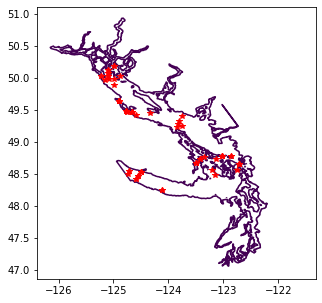

In [175]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax.plot(data2.Lon,data2.Lat,'r*')

In [178]:
data2.loc[(data2.Lat<49.8)&(data2.Lat>49.3)&(data2.Lon<-124.2)]

,dtUTC,Lat,Lon,mod_PAR,PAR,staFile2,obsFile2
156121,2017-04-15 18:06:31,49.639833,-124.894333,326.176690,1489.8,2017-03-0005.ctd,2017-03-0005.ctd
157571,2017-04-18 17:26:25,49.636833,-124.892500,327.003640,1419.4,2017-03-0052.ctd,2017-03-0052.ctd
179543,2017-06-28 15:59:27,49.639667,-124.894500,113.446298,1401.1,2017-56-0003.ctd,2017-56-0003.ctd
179572,2017-06-28 17:04:42,49.639500,-124.894667,249.491817,1648.8,2017-56-0004.ctd,2017-56-0004.ctd
179573,2017-06-28 17:04:42,49.639500,-124.894667,249.491817,1281.4,2017-56-0004.ctd,2017-56-0004.ctd
179601,2017-06-28 18:00:07,49.639500,-124.895000,312.635638,1757.9,2017-56-0005.ctd,2017-56-0005.ctd
179602,2017-06-28 18:00:07,49.639500,-124.895000,312.635638,1361.2,2017-56-0005.ctd,2017-56-0005.ctd
179630,2017-06-28 19:58:45,49.639667,-124.895167,622.294127,1950.6,2017-56-0006.ctd,2017-56-0006.ctd
179631,2017-06-28 19:58:45,49.639667,-124.895167,358.993439,1408.6,2017-56-0006.ctd,2017-56-0006.ctd
179657,2017-06-28 20:56:54,49.639500,-124.895167,678.349261,1828.6,2017-56-0007.ctd,2017-56-0007.ctd
